In [1]:
%pylab inline

from matplotlib import cm # to get a matplotlib.colors.ListedColormap
from matplotlib import style
style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Python modules for signal processing
from scipy.io import loadmat
from scipy import signal

# EEG example


From a patient in a dark room in a resting state. The recording is from the course **Master the Fourier transform and its applications**, see the link [here](https://www.udemy.com/course/fourier-transform-mxc/) from Mike X.


In [3]:
data = loadmat(file_name = './data/EEGrestingState.mat')
# transpose matrix and convert to 1D NumPy array
eeg = data['eegdata'].squeeze() # amplitude in microVolts
sr = int(data['srate']) # sampling rate in sec
time = np.arange(eeg.size)/sr
print('Sampling rate = %d samples/sec'%sr)

Sampling rate = 1024 samples/sec


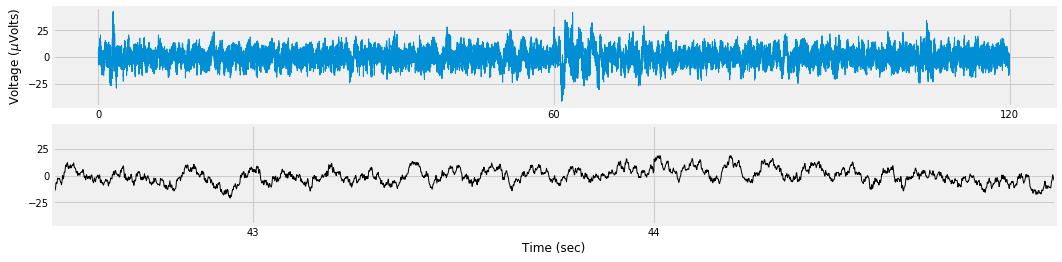

In [4]:
# plot the time course of the EEG
fig, ax = plt.subplots(2,1, figsize=(16,4), sharey=True)

ax[0].plot(time,eeg, lw=1)
ax[0].set_xlabel('Time (sec)'), ax[0].set_ylabel('Voltage ($\mu$Volts)');
ax[0].set_xticks(arange(0,130,60));

ax[1].plot(time, eeg, lw=1, color='k')
ax[1].set_xlim(42.5,45)
#ax[1].set_xlim(12,14.5)
ax[1].set_xticks(arange(43,45,1));
ax[1].set_xlabel('Time (sec)');

In [5]:
# Fourier transform
FourierCoeff = np.fft.fft(eeg)/eeg.size
DC = [np.abs(FourierCoeff[0])]
amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))  

# compute frequencies vector until half the sampling rate
Nyquist = sr/2
print('Nyquist frequency = %2.4f Hz'%Nyquist)
Nsamples = int( math.floor(eeg.size/2) )
hz = np.linspace(0, Nyquist, num = Nsamples + 1 )
dhz = hz[1]
print('Spectral resolution = %2.4f Hz'%hz[1])

Nyquist frequency = 512.0000 Hz
Spectral resolution = 0.0083 Hz


In [6]:
# Perform Welch's periodogram
segment = int( 4*sr ) 
myhann = signal.get_window('hann', segment)

# obtain the power (uV^2) spectrum with Hann window and 50% overlap
myparams = dict(fs = sr, nperseg = segment, window = myhann, noverlap = segment/2, 
                scaling = 'spectrum', return_onesided = True)
freq, ps = signal.welch(x = eeg, **myparams)# units uV**2
ps = 2*ps

# obtain the power density/Hz (uV^2) spectrum with Hann window and 50% overlap
# to get back to simply power, divide by the segment lenght in seconds (four in our case)
myparams2 = dict(fs = sr, nperseg = segment, window = myhann, noverlap = segment/2, 
                 scaling = 'density', return_onesided = True)
freq, psd = signal.welch(x = eeg, **myparams2)# units uV**2/Hz
psd = 2*psd

dfreq = freq[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

Spectral resolution = 0.2500 Hz


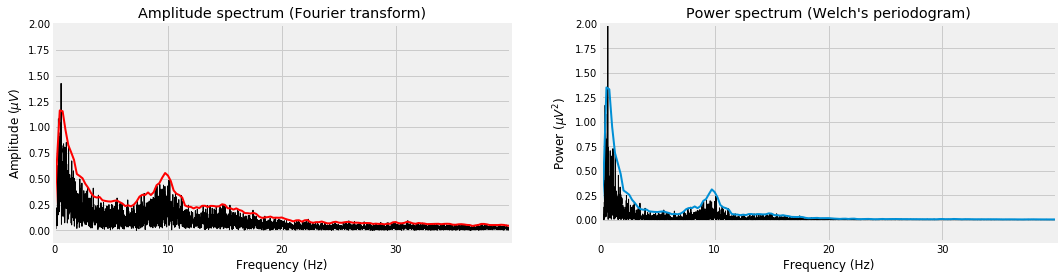

In [7]:
# Plot the power spectrum

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title("Amplitude spectrum (Fourier transform)")
ax[0].plot(hz,amp[:len(hz)], lw=1, color='k')#, use_line_collection = True)
ax[0].plot(freq, np.sqrt(ps/10), color='red', lw=2) 
ax[0].set_ylabel('Amplitude ($\mu V$)')

ax[1].set_title("Power spectrum (Welch's periodogram)")
ax[1].plot(hz, np.power(amp[:len(hz)],2), color='k', lw =1)
ax[1].plot(freq, (ps/10), color='C0', lw=2)#, use_line_collection = True)
ax[1].set_ylabel('Power ($\mu V^2$)')

for myax in ax:
    myax.set_xlabel('Frequency (Hz)')
    myax.set_xlim(0,40)
    myticks = list(range(0,40,10))
    myax.set_xticks(myticks)
    myax.set_ylim(ymax=2)

In [8]:
# compute the signal at 10 Hz
print('Signal amplitude @10 Hz     = %2.4f uVolts'%amp[int(10/dhz)]) 
print('Signal power @10 Hz         = %2.4f uVolts^2'%ps[int(10/dfreq)])
print('Singal power density @10 Hz = %2.4f uVolts^2/Hz'%psd[int(10/dfreq)])

Signal amplitude @10 Hz     = 0.2213 uVolts
Signal power @10 Hz         = 2.8198 uVolts^2
Singal power density @10 Hz = 7.5194 uVolts^2/Hz


In [9]:
# now we will analyze window lenghts of 500 ms in 25 ms steps. 
# Signals will overlap 475 ms
WinLength = int(0.5*sr) # 500 points (0.5 sec, 500 ms)
step = int(0.025*sr) # 25 points (or 25 ms)

# we have less resolution here because the signals are smaller
Nsamples = int( np.floor(WinLength/2) )
hz = np.linspace(0,Nyquist, Nsamples + 1)
dfreq = hz[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

Spectral resolution = 2.0000 Hz


In [10]:
nsteps = int(np.floor ( (eeg.size - WinLength)/step) )
print(eeg.size, nsteps)

122880 4894


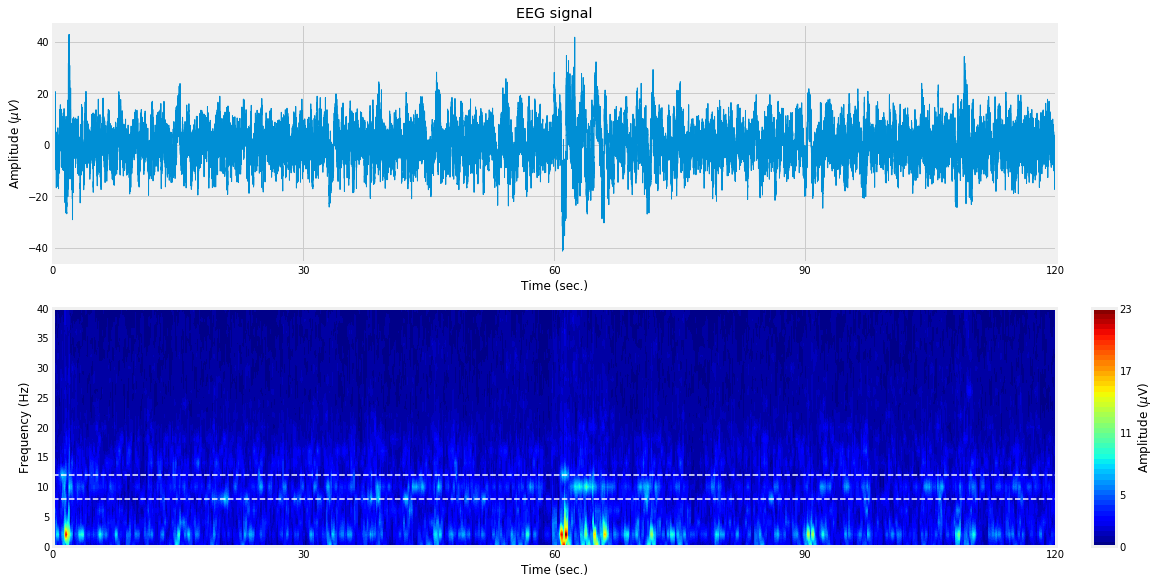

In [11]:
myamp = list()
for i in range(nsteps):
    
    # signal duration 500 ms (512 data points)
    data = eeg[i*step:i*step+WinLength]
    
    FourierCoeff = np.fft.fft(data)/WinLength
    DC = [np.abs(FourierCoeff[0])] # DC component
    amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))
    
    amp = amp[:int(45/dfreq)]
    myamp.append( amp )

power = np.power(myamp, 2)
#logpower = 10*np.log10(power)
fig, ax = plt.subplots(2,1, figsize = (16,8), constrained_layout=True)
#fig.suptitle('Time-frequency power via short-time FFT')

ax[0].plot(time, eeg, lw = 1, color='C0')
ax[0].set_ylabel('Amplitude ($\mu V$)')
ax[0].set_title('EEG signal')

# spectrum is a ContourSet object
dt = 120/nsteps # 120 seconds in number of steps
X = np.arange(nsteps)*dt
Y = hz[:int(45/dfreq)]
Z = np.array(myamp).T
levels = 45
spectrum = ax[1].contourf(X,Y,Z,levels, cmap='jet')#,'linecolor','none')

# get the colormap
cbar = plt.colorbar(spectrum)#, boundaries=np.linspace(0,1,5))
cbar.ax.set_ylabel('Amplitude ($\mu$V)', rotation=90)
cbar.set_ticks(np.arange(0,50,10))

#A working example (for any value range) with five ticks along the bar is:

m0=int(np.floor(np.min(myamp)))            # colorbar min value
m4=int(np.ceil(np.max(myamp)))             # colorbar max value
m1=int(1*(m4-m0)/4.0 + m0)               # colorbar mid value 1
m2=int(2*(m4-m0)/4.0 + m0)               # colorbar mid value 2
m3=int(3*(m4-m0)/4.0 + m0)               # colorbar mid value 3
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels([m0,m1,m2,m3,m4])

#cbar.set_ticks(np.arange(0, 1.1, 0.5))

ax[1].axhline(y = 8, linestyle='--', linewidth = 1.5, color='white')
ax[1].axhline(y = 12, linestyle='--', linewidth = 1.5, color='white')
ax[1].set_ylim([0,40])
ax[1].set_yticks(arange(0,45,5))
ax[1].set_ylabel('Frequency (Hz)')


for myax in ax:
    myax.set_xlim(0, 120)
    myax.set_xticks(np.arange(0, 121, 30))
    myax.set_xlabel('Time (sec.)')

In [43]:
signal.spectrogram?

In [50]:
myparams = dict(nperseg = WinLength, noverlap = WinLength-step, return_onesided=True, mode='magnitude')
f, nseg, Sxx = signal.spectrogram(x = eeg, fs = sr, **myparams)

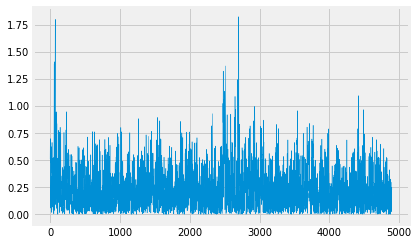

In [54]:
plt.plot(Sxx[0], lw =0.5)

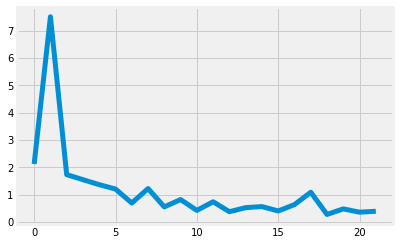

In [55]:
plt.plot(myamp[0], lw=5)

In [56]:
f[1]

2.0

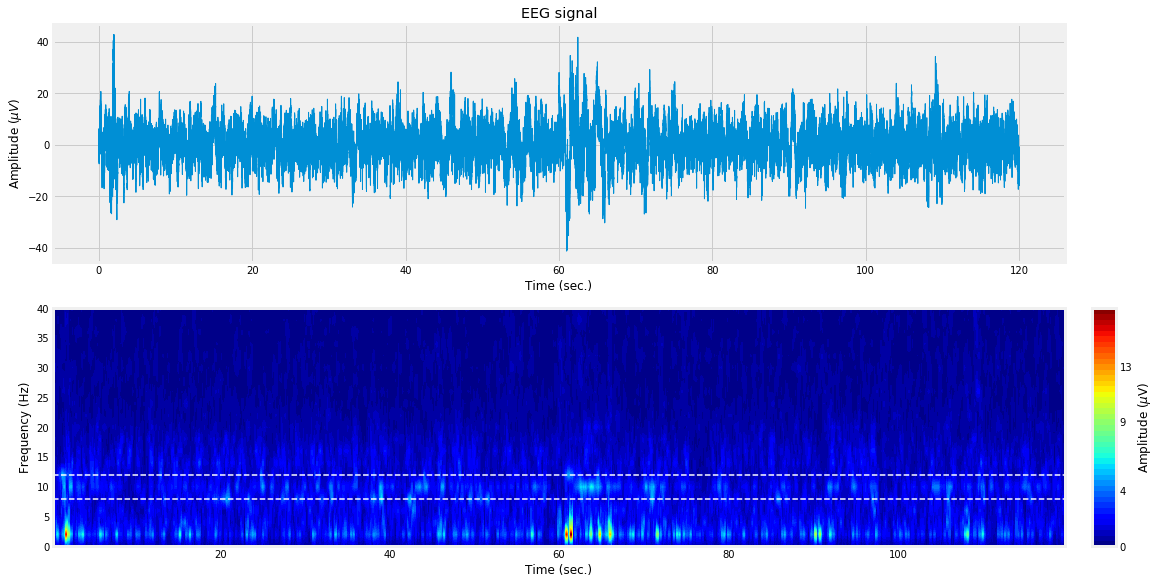

In [49]:
fig, ax = plt.subplots(2,1, figsize = (16,8), constrained_layout=True)

ax[0].plot(time, eeg, lw = 1, color='C0')
ax[0].set_ylabel('Amplitude ($\mu V$)')
ax[0].set_title('EEG signal')

# spectrum is a ContourSet object
dt = 120/nsteps # 120 seconds in number of steps
X = nseg
Y = f
Z = Sxx
levels = 45
spectrum = ax[1].contourf(X,Y,Z,levels, cmap='jet')#,'linecolor','none')

# get the colormap
cbar = plt.colorbar(spectrum)#, boundaries=np.linspace(0,1,5))
cbar.ax.set_ylabel('Amplitude ($\mu$V)', rotation=90)
cbar.set_ticks(np.arange(0,50,10))

#A working example (for any value range) with five ticks along the bar is:

m0=int(np.floor(np.min(Sxx)))            # colorbar min value
m4=int(np.ceil(np.max(Sxx)))             # colorbar max value
m1=int(1*(m4-m0)/4.0 + m0)               # colorbar mid value 1
m2=int(2*(m4-m0)/4.0 + m0)               # colorbar mid value 2
m3=int(3*(m4-m0)/4.0 + m0)               # colorbar mid value 3
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels([m0,m1,m2,m3,m4])

#cbar.set_ticks(np.arange(0, 1.1, 0.5))

ax[1].axhline(y = 8, linestyle='--', linewidth = 1.5, color='white')
ax[1].axhline(y = 12, linestyle='--', linewidth = 1.5, color='white')
ax[1].set_ylim([0,40])
ax[1].set_yticks(arange(0,45,5))
ax[1].set_ylabel('Frequency (Hz)')


for myax in ax:
    #myax.set_xlim(0, 120)
    #myax.set_xticks(np.arange(0, 121, 30))
    myax.set_xlabel('Time (sec.)')